In this iPython notebook, we **run logistic regression**. Code is largely copied from svm_logit.ipynb, but the output here is for data including an extra feature of tfbs.

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import cross_validation
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Import data</h3>

In [2]:
CELLNAME = "HelaS3"
label = "eRNA"

In [3]:
data = pd.read_table('data/' + CELLNAME + '_features.txt.gz', compression='gzip')
data.head(2)

,chr,lower,upper,H3K27ac,H3K27me3,H3K36me3,H3K4me2,H3K4me3,H3K9ac,H4K20me1,p300,eRNA,tfbs
0,10,1,200,0,0,0,0,0,0,0,0,0,0
1,10,201,400,0,0,0,0,0,0,0,0,0,0


In [4]:
feature_names = list(data.columns.values)
feature_names = feature_names[3:]
feature_names.remove(label)
print feature_names

['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1', 'p300', 'tfbs']


In [5]:
#Select positive set
positive = data[data[label]==1]
nrows = positive.shape[0]
print positive.shape

#Select negative set
use_random_sampling = False 
if use_random_sampling:
    negative = data[data[label]==0].as_matrix()
    nrows = negative.shape[0]
    select = np.random.choice(nrows, positive.shape[0]) # same size as positive set
    negative = negative[select,:]
    print negative.shape
else: # follow distribution of positive set
    indices = data[data[label]==1].index.values
    diff = np.diff(indices)
    offset = np.floor(np.mean(np.diff(indices))/2)
    select = (indices)+offset.astype(np.int64)
    mean_distance = np.mean(np.diff(indices))*200 # approximate value
    negative = data.iloc[select]
    negative = negative[negative[label]==0]
    print negative.shape

#Form sample
sample = pd.concat([positive,negative])
print sample.shape

(19817, 13)
(19709, 13)
(39526, 13)


In [6]:
X = sample.drop(['chr','lower','upper',label], axis=1).as_matrix()
print X

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 1 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [7]:
y = sample[label].as_matrix()
print y

[1 1 1 ..., 0 0 0]


In [9]:
print "Correlation between each feature and %s (Pearson corr coef)" %label
for i in range(len(feature_names)):
    print feature_names[i] + ": " + "%s" %stats.pearsonr(X[:,i], y)[0]

Correlation between each feature and eRNA (Pearson corr coef)
H3K27ac: 0.526190540936
H3K27me3: -0.0370964991584
H3K36me3: -0.0355387038548
H3K4me2: 0.557339674094
H3K4me3: 0.470475481983
H3K9ac: 0.464727074142
H4K20me1: 0.0359725521243
p300: 0.387950198971
tfbs: 0.163275615308


<h3>Run Logistic Regression</h3>

0.77910642709


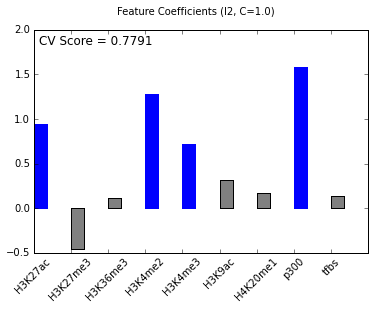

0.779055826204


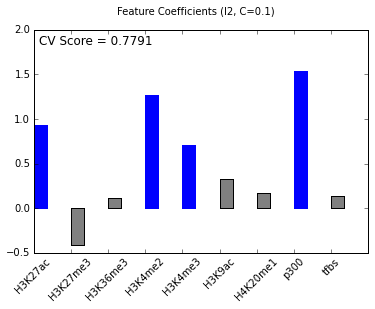

0.779055819803


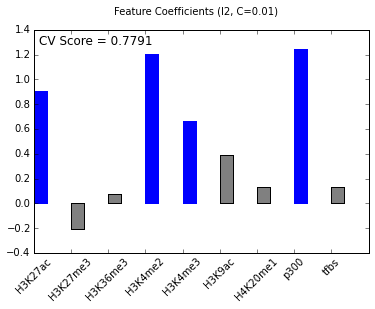

0.777057196823


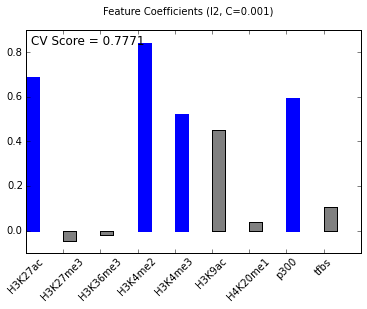

0.777917200578


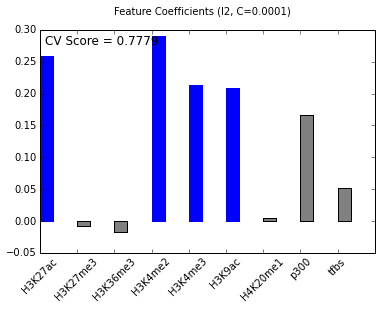

0.739386222275


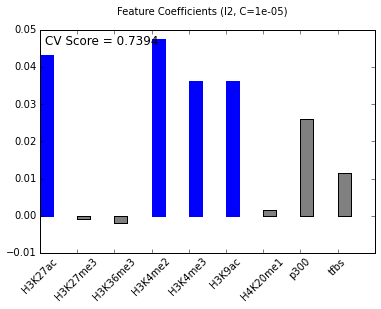

In [13]:
penalty_type = 'l2'
regs = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for reg in regs: 
    logreg = linear_model.LogisticRegression(penalty=penalty_type, C=reg)
    logreg.fit(X,y)
    scores = cross_validation.cross_val_score(logreg, X, y, cv=10)
    mean_cv = sum(scores) / float(len(scores))
    print mean_cv

    coef = logreg.coef_
    coef = [item for sublist in coef for item in sublist] #flatten list
    coef_np = np.asarray(coef)
    top_coef = np.argsort(-coef_np)[:4]

    #Plot
    ind = np.arange(len(feature_names))  
    width = 0.35       
    fig, ax = plt.subplots()
    rects = ax.bar(ind, coef, width, color='gray')
    for index in top_coef:
        rects[index].set_color('b')
    plt.xticks(range(10))
    ax.set_xticklabels(feature_names,rotation=45)
    plt.suptitle("Feature Coefficients (%s, C=%s)" %(penalty_type,reg))
    ax.annotate('CV Score = %0.4f'%mean_cv, xy=(0,1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points',
                    ha='left', va='top')
    plt.show()

Elastic Net (learned with Stochastic Gradient Descent) [unfinished work]

In [ ]:
from sklearn import linear_model
from sklearn import cross_validation
logregen = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15)
logregen.fit(X,y)
print cross_validation.cross_val_score(logregen, X, y, cv=10)